### Shifted linear interpolation
Examples based on the [paper](http://bigwww.epfl.ch/publications/blu0401.pdf): Blu T, Thévenaz P, Unser M (2004): Linear Interpolation Revitalized. IEEE Trans. Image Proc. 13(5), 710-9

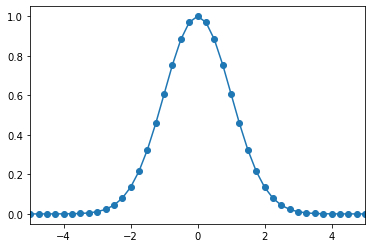

In [2]:
# Shifted linear interpolation
# 
# Interpolation of the Gaussian function
# 
import numpy as np
import matplotlib.pyplot as plt

dx = 0.25;
# vector of samples
xk = np.arange(-5,5+dx/2,dx)
fk = np.exp(-xk**2/2)
plt.plot(xk,fk,'o-');
plt.xlim([-5,5])
plt.show()

Calculation of the coefficient vector `c` and interpolation using the shifted basis points in `xks`.

In [3]:
# prefilter
def prefilter(fk,shift):
    pole=shift/(shift-1)
    zero=1/(1-shift)
    c=np.zeros(len(fk))
    c[0]=fk[0]
    for i in range(1,len(c)):
        c[i]=pole*c[i-1]+zero*fk[i]
    return c

# interpolation for arbitrary x
def slintp(x,xks,c):
    dx=xks[1]-xks[0]
    if x<=xks[0]:
        return c[0]
    else:
        nk = (x-xks[0])/dx
        k = int(nk)
        deltax = dx*(nk-k)
        #print(deltax/dx)
        return (c[k]*(dx-deltax)+c[k+1]*deltax)/dx


Residuals of the shifted linear interpolation

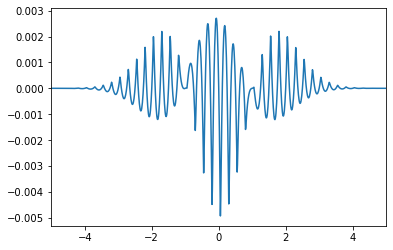

std: 0.000876


In [4]:
# optimum shift
shift = 0.21
# shifted node vector
xks = xk+shift*dx
# shifted linear interpolation
xi = np.arange(-5,5.005,0.01)
nxi = len(xi)
fi = np.zeros(nxi)
c  = prefilter(fk,shift)
#print(len(c)) # 41
for i in range(0,nxi):
    fi[i] = slintp(xi[i],xks,c)
dfis=np.exp(-xi**2/2)-fi

plt.plot(xi,dfis)
plt.xlim([-5,5])
plt.show()

# standard deviation of residuals
L2s = np.std(dfis)  # 0.000876
print("std: {:.6f}".format(L2s))

Traditional linear interpolation

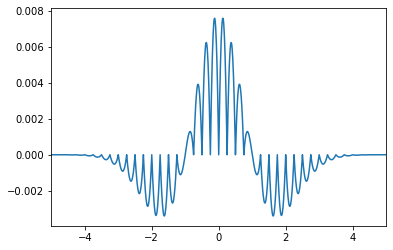

std: 0.002072


In [5]:
# not shifted linear interpolation
shift = 0.0
xks = xk+shift*dx
c  = prefilter(fk,shift)
for i in range(0,nxi):
    fi[i] = slintp(xi[i],xks,c)
dfil=np.exp(-xi**2/2)-fi

plt.plot(xi,dfil)
plt.xlim([-5,5])
plt.show()

L2l = np.std(dfil)  # 0.002072
print("std: {:.6f}".format(L2l))

Gain of the shifted linear interpolation

gain: 7.476 dB


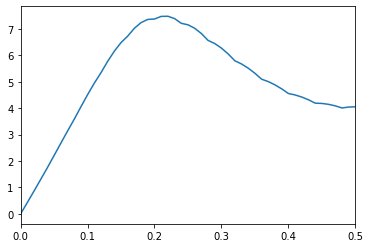

In [6]:
# gain of shifted linear interpolation dB
dBgain = 20*np.log10(L2l/L2s)  # 7.476
print("gain: {:.3f} dB".format(dBgain))


# interpolation gain in terms of shift
def gain(shift):
    dx = 0.25;
    xk = np.arange(-5,5+dx/2,dx)
    fk = np.exp(-xk**2/2)
    xks = xk+shift*dx
    xi = np.arange(-5,5.005,0.01)
    nxi = len(xi)
    fi = np.zeros(nxi)
    c  = prefilter(fk,shift)
    for i in range(0,nxi):
        fi[i] = slintp(xi[i],xks,c)
    dfis=np.exp(-xi**2/2)-fi
    L2s = np.std(dfis)
    L2l = 0.002072
    return 20*np.log10(L2l/L2s)

s = np.arange(0,0.5+0.005,0.01)
gs = np.zeros_like(s)
ns = len(s)
for i in range(ns):
    gs[i] = gain(s[i])

plt.plot(s,gs)
plt.xlim([0,0.5])
plt.show()

Prefilter coefficients

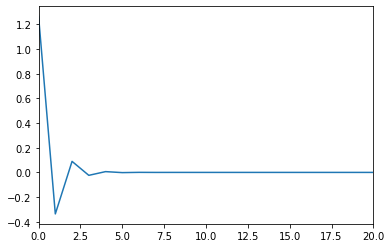

In [7]:
# h(n) prefilter coefficients
tau = 0.21
kvec = np.arange(0,101)
hn = (-1)**kvec/(1-tau)*(tau/(1-tau))**kvec

plt.plot(kvec[:21],hn[:21])
plt.xlim([0,20])
plt.show()

Synthesis function (interpolating)

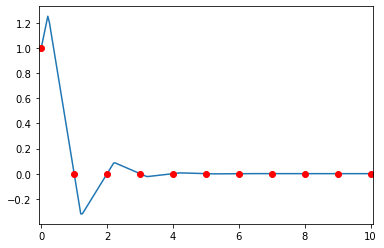

In [8]:
def hat(x):
    if np.abs(x)>1:
        return 0
    else:
        return 1-np.abs(x)

def fint(x,hn,tau):
    f = 0
    n = len(hn)
    for i in range(n):
        f = f + hn[i]*hat(x-i-tau)
    return f

xf = np.arange(0,10+0.02,0.05)
f = np.zeros_like(xf)
for i in range(len(xf)):
    f[i] = fint(xf[i],hn,tau)

# plot of the synthesis function
plt.plot(xf,f)
x0 = np.arange(0,11)
z0 = np.zeros_like(x0); z0[0]=1
plt.plot(x0,z0,'ro')
plt.xlim([-0.08,10.08])
plt.show()


# Image interpolation

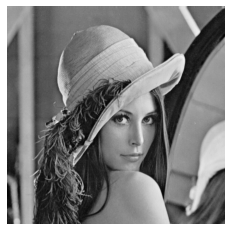

In [10]:
import matplotlib.image as mpimg
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img = mpimg.imread('img/lena.png')
l = rgb2gray(img)
plt.imshow(l, cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

**shift**

conventional linear interpolation: 0

shifted linear interpolation: $\left( \frac{1}{2} - \frac{1}{\sqrt{12}} \right)$

In [11]:
shift = 0.0

In [13]:
# 2D prefilter of s in-place
# convert the image samples into interpolation coefficients
def samp2coeff(s,shift):
    (h,w) = s.shape
    for i in range(h):
        ci = prefilter(s[i,:],shift)
        s[i,:] = ci
    for j in range(w):
        cj = prefilter(s[:,j],shift)
        s[:,j] = cj
    #return s

# interpolation of shifted-linear coefficients c for x, y
def interpxy(c,w,h,x,y,shift):
    # perform the shift
    x -= shift
    y -= shift
    # compute the interpolation indexes
    i = int(np.floor(x))
    j = int(np.floor(y))
    xi = np.array([i,i+1])
    yi = np.array([j,j+1])
    # compute the interpolation weights
    ww = x - xi[0]
    xw = np.array([1.0 - ww, ww])
    ww = y - yi[0]
    yw = np.array([1.0 - ww, ww])
    # check the boundaries
    for k in range(2):
        if xi[k] < 0:
            xi[k] = 0
        if w <= xi[k]:
            xi[k] = w-1
        if yi[k] < 0:
            yi[k] = 0
        if h <= yi[k]:
            yi[k] = h-1
    # perform interpolation
    interpolated = 0.0
    for j in range(2):
        ww = 0.0
        for i in range(2):
            ww += xw[i] * c[yi[j], xi[i]]
        interpolated += yw[j] * ww
    return interpolated

## image rotation test

In [15]:
# keep the original image
ll = np.copy(l)
(h,w) = l.shape

# rotation angle step
astep = 60
nrot = int(360/astep)

for n in range(nrot):

    print("rotation {:d} of {:d}".format(n+1,nrot))
    # change of basis of ll
    samp2coeff(ll,shift)

    # prepare the geometry
    # rotation angle
    angle = astep
    # shift
    xs = 0
    ys = 0
    # rotation origin
    xo = w//2
    yo = h//2
    angle *= np.pi / 180.0
    a11 = np.cos(angle)
    a12 = -np.sin(angle)
    a21 = np.sin(angle)
    a22 = np.cos(angle)
    x0 = a11 * (xs + xo) + a12 * (ys + yo)
    y0 = a21 * (xs + xo) + a22 * (ys + yo)
    xs = xo - x0
    ys = yo - y0

    # visit all pixels of the output image and assign their value
    oi = np.zeros_like(l)
    p = oi.flatten('C')
    i = 0
    for y in range(h):
        x0 = a12 * y + xs
        y0 = a22 * y + ys
        for x in range(w):
            x1 = x0 + a11 * x
            y1 = y0 + a21 * x
            if (x1 <= -0.5) or ((w - 0.5) <= x1) or (y1 <= -0.5) or ((h - 0.5) <= y1):
                p[i] = 0.0
                i = i + 1	
            else:
                p[i] = interpxy(ll, w, h, x1, y1, shift)
                i = i + 1

    p = p.reshape(l.shape)
    ll = p

rotation 1 of 6
rotation 2 of 6
rotation 3 of 6
rotation 4 of 6
rotation 5 of 6
rotation 6 of 6


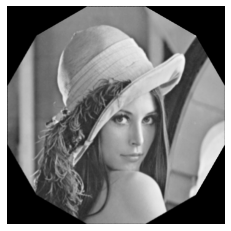

In [16]:
plt.imshow(p, cmap = 'gray')
plt.axis('off')
plt.show()

In [17]:
shift = (0.5 - np.sqrt(1.0 / 12.0))

In [18]:
ll = np.copy(l)

for n in range(nrot):

    print("rotation {:d} of {:d}".format(n+1,nrot))
    # change of basis of ll
    samp2coeff(ll,shift)

    # prepare the geometry
    # rotation angle
    angle = astep
    # shift
    xs = 0
    ys = 0
    # rotation origin
    xo = w//2
    yo = h//2
    angle *= np.pi / 180.0
    a11 = np.cos(angle)
    a12 = -np.sin(angle)
    a21 = np.sin(angle)
    a22 = np.cos(angle)
    x0 = a11 * (xs + xo) + a12 * (ys + yo)
    y0 = a21 * (xs + xo) + a22 * (ys + yo)
    xs = xo - x0
    ys = yo - y0

    # visit all pixels of the output image and assign their value
    oi = np.zeros_like(l)
    p = oi.flatten('C')
    i = 0
    for y in range(h):
        x0 = a12 * y + xs
        y0 = a22 * y + ys
        for x in range(w):
            x1 = x0 + a11 * x
            y1 = y0 + a21 * x
            if (x1 <= -0.5) or ((w - 0.5) <= x1) or (y1 <= -0.5) or ((h - 0.5) <= y1):
                p[i] = 0.0
                i = i + 1	
            else:
                p[i] = interpxy(ll, w, h, x1, y1, shift)
                i = i + 1

    p = p.reshape(l.shape)
    ll = p

rotation 1 of 6
rotation 2 of 6
rotation 3 of 6
rotation 4 of 6
rotation 5 of 6
rotation 6 of 6


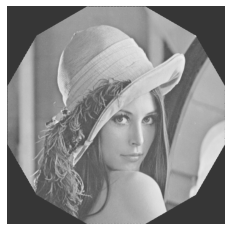

In [19]:
plt.imshow(p, cmap = 'gray')
plt.axis('off')
plt.show()